Thư viện

In [ ]:
!pip install torch torchvision torchaudio numpy pandas matplotlib

In [ ]:
!pip install kagglehub

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.70G/2.70G [02:03<00:00, 23.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset

from torch.cuda.amp import autocast, GradScaler
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms



In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


Using device: cuda
NVIDIA GeForce RTX 3090


In [3]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [4]:
train_path = r"/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"

In [5]:
if os.path.exists(train_path):
    print("Đã tìm thấy thư mục!")

    ds_for_train = ImageFolder(train_path, transform=train_transform)
    ds_for_val = ImageFolder(train_path, transform=val_transform)

    train_size = int(0.8 * len(ds_for_train))
    val_size = len(ds_for_train) - train_size
    indices = torch.arange(len(ds_for_train))

    train_indices, val_indices = random_split(
        indices,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_ds = Subset(ds_for_train, train_indices)
    val_ds = Subset(ds_for_val, val_indices)

    print(f"Thành công! Số lớp: {len(ds_for_train.classes)}")
    print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")
else:
    print("Vẫn sai đường dẫn. Hãy chạy lệnh !ls /content/drive/MyDrive để mình xem tên folder chính xác nhé.")


Đã tìm thấy thư mục!
Thành công! Số lớp: 38
Train size: 56236, Val size: 14059


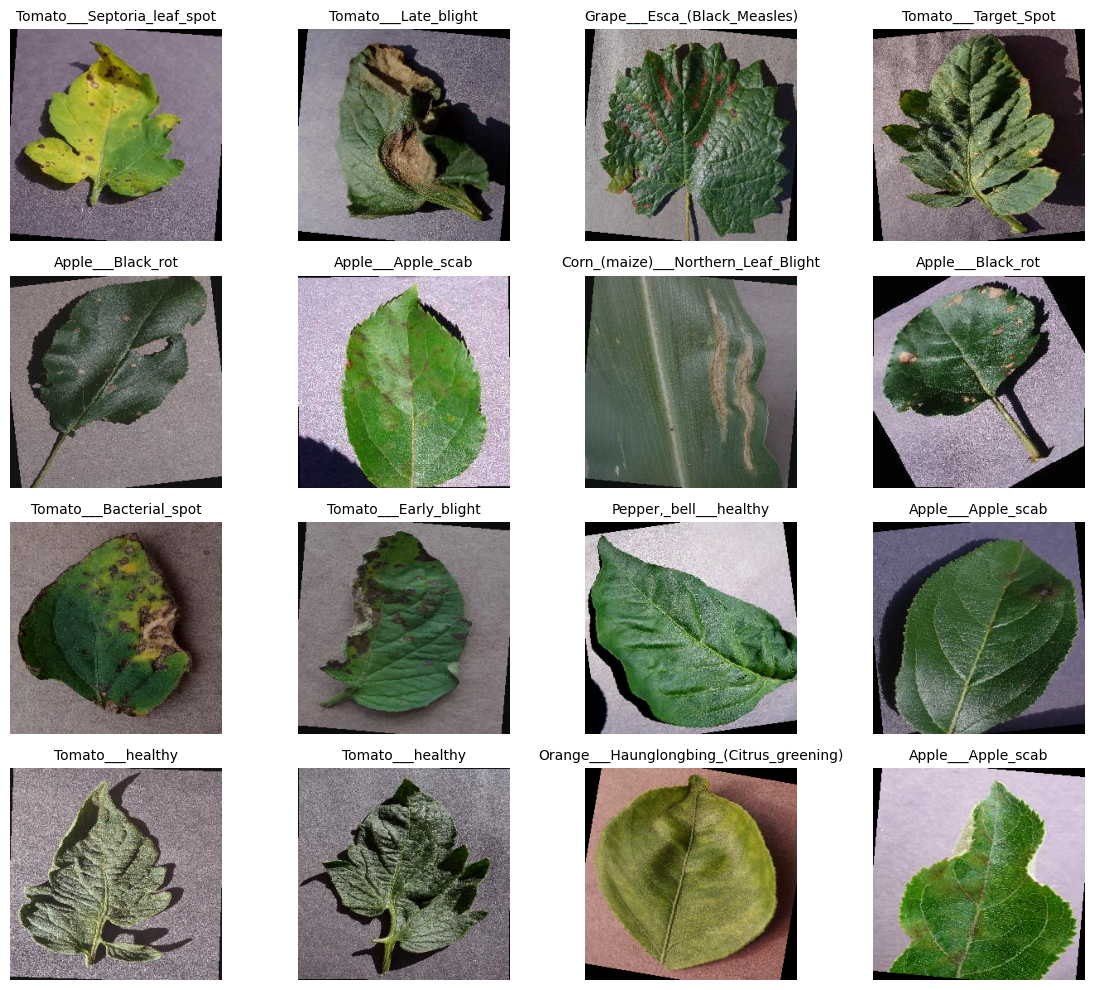

In [6]:


def imshow_grid(imgs, labels, dataset_classes, denormalize=True, figsize=(10, 8)):
    num_imgs = len(imgs)
    if num_imgs > 16:
        imgs = imgs[:16]
        labels = labels[:16]
    
    ncols = min(num_imgs, 4)
    nrows = (num_imgs + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(num_imgs):
        ax = axes[i]
        img = imgs[i].cpu().numpy()
        if denormalize:
            img = img.transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1)
        else:
            img = img.transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(dataset_classes[labels[i]], fontsize=10)
        ax.axis('off')
    
    for i in range(num_imgs, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

if 'train_ds' in locals():
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    
    # 1. Lấy một batch ảnh
    images, labels = next(iter(train_loader))

    # 2. Hiển thị (Sử dụng ds_for_train.classes từ ImageFolder gốc)
    imshow_grid(images, labels, ds_for_train.classes, denormalize=True, figsize=(12, 10))
else:
    print("Lỗi: Bạn chưa chạy đoạn code định nghĩa 'train_ds'!")

In [7]:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)


In [8]:
num_classes = len(ds_for_train.classes)

model = models.resnet18(weights="IMAGENET1K_V1")

model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
print(f"Model đã sẵn sàng với {num_classes} lớp đầu ra.")


Model đã sẵn sàng với 38 lớp đầu ra.


In [9]:
print(torch.__version__)

2.9.1+cu128


In [10]:
from torch import nn
from torch.amp import GradScaler

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

scaler = GradScaler('cuda', enabled=(device.type == "cuda"))
torch.backends.cudnn.benchmark = True

In [11]:
@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.amp.autocast('cuda'):
            out = model(x)
            loss = criterion(out, y)

        out = model(x)
        loss = criterion(out, y)

        total_loss += loss.item()
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss / len(loader), correct / total


In [12]:
# 2. Hàm Validate (Kiểm tra độ chính xác sau mỗi epoch)
def validate(model, loader, criterion, decvice):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
            
            _, predicted = out.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
            
    avg_loss = val_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [14]:
import sys
!{sys.executable} -m pip install -U tqdm

In [18]:
from tqdm.auto import tqdm
epochs = 15  
checkpoint_path = "last_checkpoint.pth"
best_model_path = "resnet18_best.pth"
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = (device.type == "cuda")
scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

start_epoch = 0
if os.path.exists(checkpoint_path):
    print(f"--> Tìm thấy checkpoint! Đang tải lại...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint.get('best_val_loss', float("inf"))
    print(f"--> Tiếp tục từ Epoch {start_epoch + 1}")
else:
    best_val_loss = float("inf")
    print("--> Bắt đầu huấn luyện từ đầu (Epoch 1)")

for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            out = model(x)
            loss = criterion(out, y)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss = running_loss / len(train_loader)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"\n[Kết quả Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    checkpoint_data = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss
    }
    torch.save(checkpoint_data, checkpoint_path)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("--> Đã cập nhật model tốt nhất!")

    if epoch == 7:
        for g in optimizer.param_groups:
            g["lr"] = 1e-4

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--> Bắt đầu huấn luyện từ đầu (Epoch 1)


Epoch 1/15:   0%|          | 0/879 [00:00<?, ?it/s]

Epoch 1/15: 100%|██████████| 879/879 [01:03<00:00, 13.85it/s, loss=0.7831]



[Kết quả Epoch 1] Train Loss: 0.8981 | Val Acc: 97.38%
--> Đã cập nhật model tốt nhất!


Epoch 2/15: 100%|██████████| 879/879 [00:39<00:00, 22.25it/s, loss=0.7307]



[Kết quả Epoch 2] Train Loss: 0.7610 | Val Acc: 98.14%
--> Đã cập nhật model tốt nhất!


Epoch 3/15: 100%|██████████| 879/879 [00:39<00:00, 22.41it/s, loss=0.7201]



[Kết quả Epoch 3] Train Loss: 0.7374 | Val Acc: 98.70%
--> Đã cập nhật model tốt nhất!


Epoch 4/15: 100%|██████████| 879/879 [00:39<00:00, 22.40it/s, loss=0.7440]



[Kết quả Epoch 4] Train Loss: 0.7299 | Val Acc: 98.84%


Epoch 5/15: 100%|██████████| 879/879 [00:39<00:00, 22.19it/s, loss=0.7311]



[Kết quả Epoch 5] Train Loss: 0.7166 | Val Acc: 99.04%
--> Đã cập nhật model tốt nhất!


Epoch 6/15: 100%|██████████| 879/879 [00:39<00:00, 22.26it/s, loss=0.7159]



[Kết quả Epoch 6] Train Loss: 0.7142 | Val Acc: 97.68%


Epoch 7/15: 100%|██████████| 879/879 [00:39<00:00, 22.33it/s, loss=0.7169]



[Kết quả Epoch 7] Train Loss: 0.7113 | Val Acc: 99.26%
--> Đã cập nhật model tốt nhất!


Epoch 8/15: 100%|██████████| 879/879 [00:39<00:00, 22.10it/s, loss=0.7066]



[Kết quả Epoch 8] Train Loss: 0.7035 | Val Acc: 99.13%


Epoch 9/15: 100%|██████████| 879/879 [00:39<00:00, 22.24it/s, loss=0.6795]



[Kết quả Epoch 9] Train Loss: 0.6835 | Val Acc: 99.75%
--> Đã cập nhật model tốt nhất!


Epoch 10/15: 100%|██████████| 879/879 [00:39<00:00, 22.22it/s, loss=0.6783]



[Kết quả Epoch 10] Train Loss: 0.6786 | Val Acc: 99.81%
--> Đã cập nhật model tốt nhất!


Epoch 11/15: 100%|██████████| 879/879 [00:39<00:00, 22.33it/s, loss=0.6749]



[Kết quả Epoch 11] Train Loss: 0.6772 | Val Acc: 99.84%
--> Đã cập nhật model tốt nhất!


Epoch 12/15: 100%|██████████| 879/879 [00:39<00:00, 22.29it/s, loss=0.6886]



[Kết quả Epoch 12] Train Loss: 0.6763 | Val Acc: 99.84%
--> Đã cập nhật model tốt nhất!


Epoch 13/15: 100%|██████████| 879/879 [00:39<00:00, 22.11it/s, loss=0.6751]



[Kết quả Epoch 13] Train Loss: 0.6759 | Val Acc: 99.83%
--> Đã cập nhật model tốt nhất!


Epoch 14/15: 100%|██████████| 879/879 [00:39<00:00, 22.32it/s, loss=0.6778]



[Kết quả Epoch 14] Train Loss: 0.6751 | Val Acc: 99.84%
--> Đã cập nhật model tốt nhất!


Epoch 15/15: 100%|██████████| 879/879 [00:39<00:00, 22.26it/s, loss=0.6736]



[Kết quả Epoch 15] Train Loss: 0.6748 | Val Acc: 99.83%
--> Đã cập nhật model tốt nhất!


In [20]:
scaler = torch.amp.GradScaler('cuda', enabled=(device.type == "cuda"))

best_val_loss = float("inf")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Cập nhật cách dùng autocast mới: torch.amp.autocast
        with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
    # Tính toán loss trung bình của tập Train
    train_loss = running_loss / len(train_loader)

    # Đánh giá trên tập Validation (sử dụng hàm validate đã định nghĩa)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # In kết quả sau mỗi Epoch
    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc*100:.2f}%"
    )

    # Lưu lại model có kết quả tốt nhất trên tập Val
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "resnet18_best.pth")
        print(f"--> Đã lưu model tốt nhất tại Epoch {epoch+1}")

    # Chiến lược giảm Learning Rate thủ công tại epoch số 8 (index 7)
    if epoch == 7:
        for g in optimizer.param_groups:
            g["lr"] = 1e-4
        print("--> Đã hạ Learning Rate xuống 1e-4")

Epoch [1/15] | Train Loss: 0.6740 | Val Loss: 0.6766 | Val Acc: 99.84%
--> Đã lưu model tốt nhất tại Epoch 1
Epoch [2/15] | Train Loss: 0.6736 | Val Loss: 0.6764 | Val Acc: 99.86%
--> Đã lưu model tốt nhất tại Epoch 2
Epoch [3/15] | Train Loss: 0.6736 | Val Loss: 0.6771 | Val Acc: 99.84%
Epoch [4/15] | Train Loss: 0.6734 | Val Loss: 0.6765 | Val Acc: 99.86%
Epoch [5/15] | Train Loss: 0.6731 | Val Loss: 0.6779 | Val Acc: 99.77%
Epoch [6/15] | Train Loss: 0.6728 | Val Loss: 0.6764 | Val Acc: 99.86%
Epoch [7/15] | Train Loss: 0.6728 | Val Loss: 0.6757 | Val Acc: 99.87%
--> Đã lưu model tốt nhất tại Epoch 7
Epoch [8/15] | Train Loss: 0.6727 | Val Loss: 0.6761 | Val Acc: 99.87%
--> Đã hạ Learning Rate xuống 1e-4
Epoch [9/15] | Train Loss: 0.6726 | Val Loss: 0.6754 | Val Acc: 99.90%
--> Đã lưu model tốt nhất tại Epoch 9
Epoch [10/15] | Train Loss: 0.6723 | Val Loss: 0.6761 | Val Acc: 99.83%
Epoch [11/15] | Train Loss: 0.6725 | Val Loss: 0.6762 | Val Acc: 99.84%
Epoch [12/15] | Train Loss: 0.

In [ ]:
# Đoạn code để nạp lại model đã lưu
model.load_state_dict(torch.load("resnet18_best.pth"))
model.to(device)
print("Đã nạp lại model thành công, bạn có thể train tiếp!")

In [21]:
test_path = r"/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/test/test/"

In [23]:
from PIL import Image
from pathlib import Path

model.load_state_dict(torch.load("./resnet18_best.pth", map_location=device))
model.eval()

# test_path = "./test"
test_root = Path(test_path)

img_paths = [p for p in test_root.rglob("*") if p.suffix.lower() in [".jpg", ".png"]]

for p in img_paths:
    img = Image.open(p).convert("RGB")
    x = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        pred = out.argmax(dim=1).item()

    print(p.name, ds_for_train.classes[pred])


PotatoHealthy1.JPG Potato___healthy
TomatoYellowCurlVirus3.JPG Tomato___Tomato_Yellow_Leaf_Curl_Virus
TomatoEarlyBlight2.JPG Tomato___Early_blight
PotatoHealthy2.JPG Potato___healthy
PotatoEarlyBlight5.JPG Potato___Early_blight
TomatoHealthy3.JPG Tomato___healthy
AppleScab1.JPG Apple___Apple_scab
PotatoEarlyBlight1.JPG Potato___Early_blight
PotatoEarlyBlight2.JPG Potato___Early_blight
TomatoEarlyBlight3.JPG Tomato___Early_blight
TomatoHealthy2.JPG Tomato___healthy
TomatoEarlyBlight6.JPG Tomato___Early_blight
TomatoEarlyBlight5.JPG Tomato___Early_blight
TomatoHealthy4.JPG Tomato___healthy
TomatoYellowCurlVirus4.JPG Tomato___Tomato_Yellow_Leaf_Curl_Virus
AppleScab2.JPG Apple___Apple_scab
AppleScab3.JPG Apple___Apple_scab
CornCommonRust2.JPG Corn_(maize)___Common_rust_
CornCommonRust3.JPG Corn_(maize)___Common_rust_
PotatoEarlyBlight4.JPG Potato___Early_blight
TomatoEarlyBlight4.JPG Tomato___Early_blight
PotatoEarlyBlight3.JPG Potato___Early_blight
AppleCedarRust4.JPG Apple___Cedar_apple_